# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

> **Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

Here are some metrics that can be used to compare 2 distributions $p_D$ and $p_\theta$ defined on $\mathcal X$:

- **Kullback-Leibler divergence**: 
  $$D_{KL}(p_D \Vert p_\theta) = \sum_{x\in\mathcal X} p_D(x) \log \left( \frac {p_D(x)}{p_\theta(x)} \right)$$
  The KL divergence is the expectation of the log difference between the probability of data in the original distribution with the approximating distribution. It measures how many information we expect to lose when we approximate one distribution with the other. It is also called *relative entropy*. 
  ___
- **Jensen-Shannon divergence**: 
  $$JSD(p_D \Vert p_\theta) = \frac{1}{2} D_{KL} \left( p_D \bigg\Vert \frac{p_D + p_\theta}{2} \right) +  \frac{1}{2} D_{KL} \left( p_\theta \bigg\Vert \frac{p_D + p_\theta}{2} \right)  $$

  It is a symmetric and smoothed version of the KL divergence. 
  ___
- **Optimal Transport Distance** or Wasserstein metric or Earth Mover Distance:

  First, we must define a ground cost function $c(x,y)$ for $x,y \in \mathcal X$ (for instance $\Vert x-y \Vert$ but it can be more complex depending on the case). We assume $c = d^p$ where $d$ is a distance on $\mathcal X$.
  The $p$-Wasserstein distance on $\mathcal X$ is 
  $$ \mathcal W (p_D \Vert p_\theta) = \left( \min_{X,Y} \mathbb E_{X\sim p_D, Y\sim p_\theta}\left[ c(X,Y) \right] \right)^{1/p}$$ 
  It represents the minimum cost needed to turn one distribution into another. In practice, it is useful to add an entropic regularization term to the cost that allows to efficiently compute the distance thanks to the Sinkhorn algorithm.
  ___
- **Maximum Mean Discrepancy** :

  The MMD is defined by a feature map $\varphi:\mathcal X \rightarrow \mathcal H$, where $H$ is a reproducing kernel Hilbert space. Then:
  $$ MMD(p_D \Vert p_\theta) = \left\Vert \mathbb E_{X\sim p_D}\left[ \varphi(X) \right] - \mathbb E_{Y\sim p_\theta}\left[ \varphi(Y) \right] \right\Vert_{\mathcal H}$$
  In the simple case of $\varphi = Id$, we fall back on the distance between the means of the 2 distributions. By choosing a more adequate kernel, the $MMD can be a better metric.


Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

> **Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

- **Those that compare the density of the distributions**

  Often, those metrics are less accurate. The KL divergence for instance is not a distance (a distance needs non-negativity, symmetry, and triangle inequality). Moreover, they are not good to compare distributions that are defined on a continuous space, and they can lead to convergence towards local minima. Some of them, such as the KL or the JS divergences also need the 2 distributions to have non zero probability on the same points (otherwise $\log \left( \frac {p_D(x)}{p_\theta(x)} \right)$ is not defined). That is very unlikely for continuous spaces (but works well for classification tasks). Finally, the density may not always be available, and even if it is, metrics which use continuous sums or integrals do not always come with a closed form, which can be hard to approximate espacially in high dimensions.

- **Those that compare the values sampled from them**

  The need to sample from the distribution can be computationaly heavy, or even intractable in some cases when the density is too difficult to approximate. Moreover, if not enough points are sampled to compute the metric between the 2 distributions, this metric can reveal to not be representative of the real distributions.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

> **Q3: What is, a priori, the impact of the choice of $N$, the dimension of the input noise $\epsilon$?**

$N$ determines the number of features of $\epsilon$, so the dimension of the input of $f_\theta$. The higher $N$ is, the more complex distribution $f_\theta$ can generate. For instance, if we want to generate large images of faces, given a small $N$, say 10, the distribution of colors over all the pixels of the images would be defined by the small $10$-dimension random number vector and would hardly fill up the whole high dimensional space that would represent the space of *faces*.

However, in addition to be more computationaly expansive, choosing $N$ too high could lead to unwanted behavior because of the curse of dimensionality (it would be hard for the generated distribution too converge towards the original one). For instance, in high dimension, the number of samples needed to cover the space grow exponentialy with respect to the dimension. 

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ \log\left(\frac{2p_D}{p_D+p_\theta}\right) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ \log\left(\frac{2p_\theta}{p_D+p_\theta} \right) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

> **Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

This formulation can be difficult to train due to the terms in $\log$ having poor convergence when the $p_\theta$ differs from $p_D$ too much. Indeed, the JS measure becomes less meaningful about convergence of distributions if their intersection with the support of the limit-distribution has measure zero (idea already encountered in question 2). Indeed, we can note that the $JSD$ metric is upper bounded by $\log(2)$, this might create saturation when $p_\theta$ differs from $p_D$. It could lead to vanishing gradients or converging toward local minima.

Similarly, in the case where the discriminator is perfect, $D(x)=1$, $\forall x \sim p_D$ and $D(x)=0$, $\forall x \sim p_\theta$. Therefore the loss function $\mathcal L$ is zero and so is the gradient.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

> **Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

The problem it may cause is that the generator only produces a small variety of outputs, that are able to trick the discriminator. But, even though the generator is able to trick the corresponding discriminator, it fails to learn a complete representation of the data. This is often referred to as *Mode Collapse*, since the generator collapse into a small subspace of the manifold on which the data come from.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

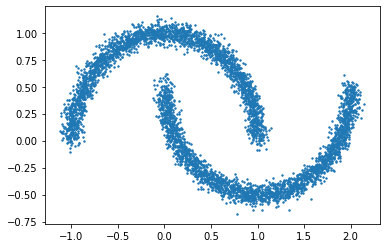

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, depth=2, width=16):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, width)
        self.fcs = nn.ModuleList()
        for _ in range(depth-2):
            self.fcs.append(nn.Linear(width, width))
        self.fc_last = nn.Linear(width, 2)
        self.activation = nn.Tanh() 
        
    def __call__(self, z):
        z = self.activation(self.fc1(z))
        for fc in self.fcs:
            z = self.activation(fc(z))
        z = self.fc_last(z)
        return z
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, depth=2, width=16):
        super().__init__()
        self.fc1 = nn.Linear(2, width)
        self.fcs = nn.ModuleList()
        for _ in range(depth-2):
            self.fcs.append(nn.Linear(width, width))
        self.fc_last = nn.Linear(width, 1)
        self.activation = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def __call__(self, x):
        x = self.activation(self.fc1(x))
        for fc in self.fcs:
            x = self.activation(fc(x))
        x = self.sigmoid(self.fc_last(x))
        return x

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.397e+00, generator: 6.287e-01


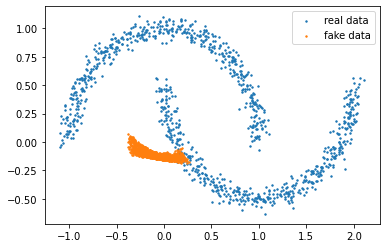

step 1000: discriminator: 1.375e+00, generator: 6.867e-01


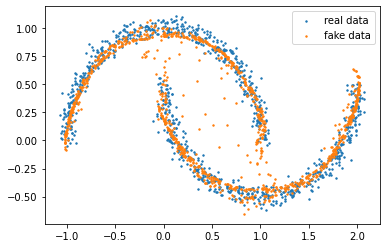

step 2000: discriminator: 1.391e+00, generator: 7.168e-01


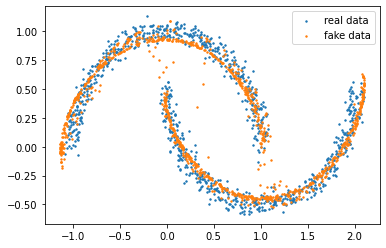

step 3000: discriminator: 1.385e+00, generator: 6.989e-01


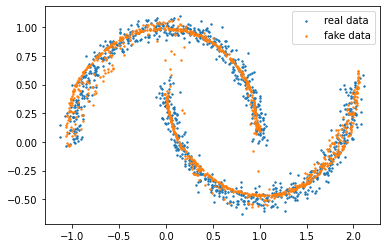

step 4000: discriminator: 1.388e+00, generator: 6.951e-01


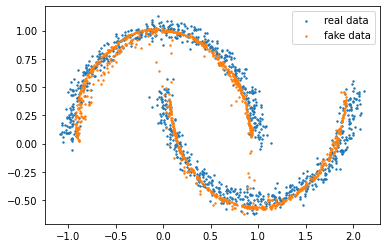

step 5000: discriminator: 1.387e+00, generator: 6.909e-01


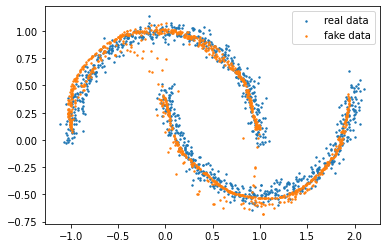

step 6000: discriminator: 1.386e+00, generator: 6.973e-01


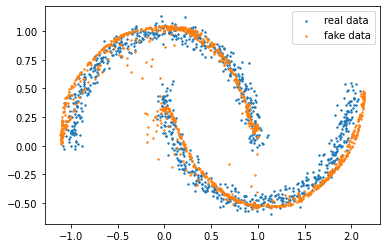

step 7000: discriminator: 1.387e+00, generator: 6.938e-01


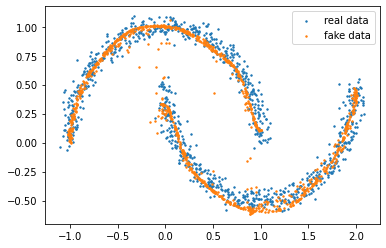

step 8000: discriminator: 1.390e+00, generator: 6.984e-01


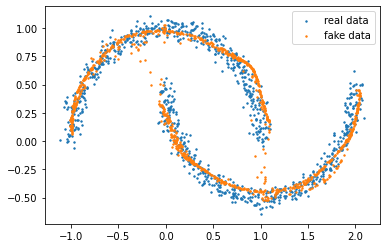

step 9000: discriminator: 1.392e+00, generator: 6.911e-01


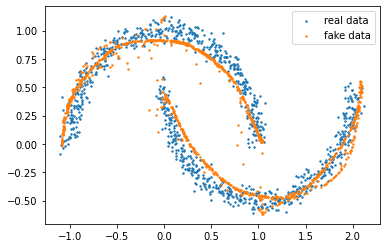

step 10000: discriminator: 1.384e+00, generator: 7.049e-01


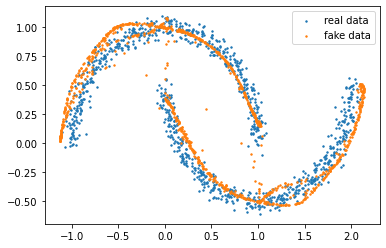

step 11000: discriminator: 1.385e+00, generator: 6.958e-01


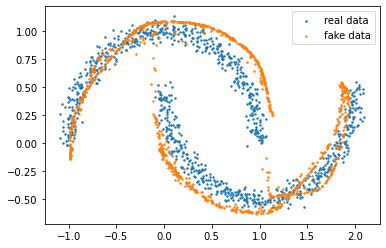

step 12000: discriminator: 1.384e+00, generator: 6.965e-01


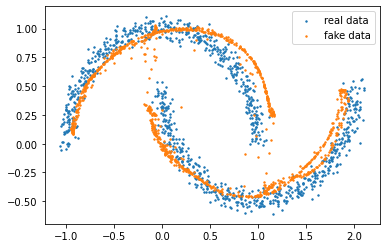

step 13000: discriminator: 1.383e+00, generator: 6.945e-01


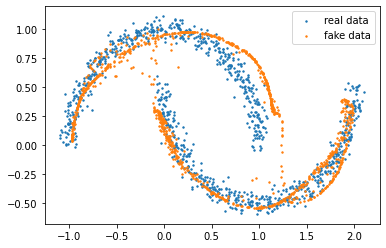

step 14000: discriminator: 1.387e+00, generator: 6.999e-01


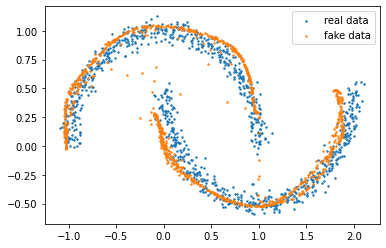

step 15000: discriminator: 1.390e+00, generator: 7.022e-01


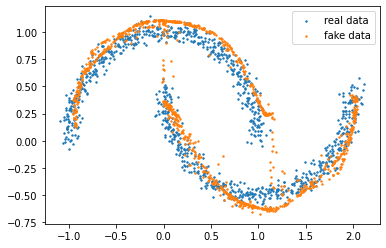

step 16000: discriminator: 1.385e+00, generator: 7.007e-01


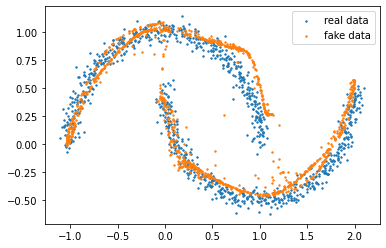

step 17000: discriminator: 1.387e+00, generator: 6.870e-01


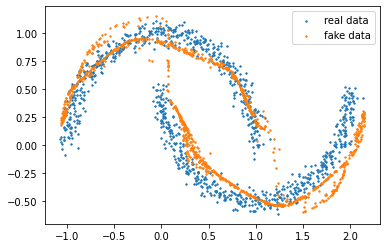

step 18000: discriminator: 1.388e+00, generator: 6.925e-01


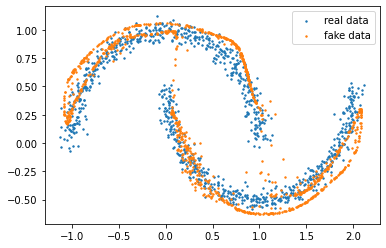

step 19000: discriminator: 1.387e+00, generator: 6.961e-01


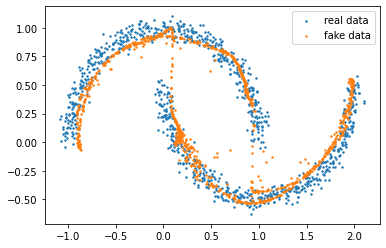

step 20000: discriminator: 1.387e+00, generator: 6.908e-01


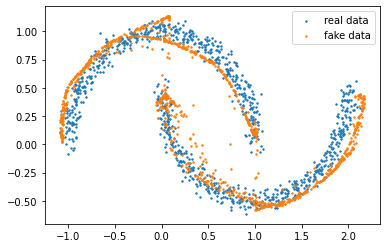

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 3
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator(depth=4, width=32)
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator(depth=4, width=32)
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

bce_loss = nn.BCELoss()

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        # real generated data
        real_batch = generate_batch(BATCHLEN)
        disc_real_out = discriminator(real_batch)
        disc_real_loss = bce_loss(disc_real_out, torch.ones(BATCHLEN,1))
        # generator generated data
        fake_batch = generator.generate(BATCHLEN)
        disc_fake_out = discriminator(fake_batch)
        disc_fake_loss = bce_loss(disc_fake_out, torch.zeros(BATCHLEN,1))
        # loss computation
        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    disc_fake_out = discriminator(fake_batch)
    gen_loss = bce_loss(disc_fake_out, torch.ones(BATCHLEN,1))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        with torch.no_grad():
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

> **Q6: Why could we anticipate that this loss could cause this?**

If the generated samples at one step of the training are well classified by the discriminator, the generator's loss becomes $0$ and the gradient vanishes, so the generator collapses. This can happen because both the generator and the discriminator share the same loss with regard to the generated samples and they are trained similtaneously. Therefore they could converge together in an equilibrium state where the generator would only generate data where the discriminator is very good, leading to a vanishing gradient.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

> **Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

- **depth / width of the generator network**

  - The bigger the network, the more complex distributions the generator is able to create. 
  - The bigger the network, the more computationaly heavy the method becomes (longer to train) 
  - We have not observed any drawback of using a bigger architecture, besides of the longer training time. Maybe using extremely large architecture can lead the generator to create artefacts in the generated distributions (such as stripes that cover the real distributions)

- **depth / width of the discriminator network**

  - The bigger the network, the more complex distributions the discriminator is able to discriminate.  
  - The bigger the network, the more computationaly heavy the method becomes (longer to train) 
  - We have not observed any drawback of using a bigger architecture, besides of the longer training time.

- **impact of `TRAIN_RATIO`**

  - First, the higher the value is, the more computationaly heavy the method becomes (longer to train)
  - If it is too high, in addition to being longer to train, there is a risk that the discriminator becomes too good on a small subset of data (depending on the BATCHLEN points generated by the generator for training the discriminator). This would lead to a $0$ loss and a vanishing gradient, and thus a GAN that only gets part of the original data distribution (mode collapse). As an example, choosing a train_ratio of $100$ led the generator to being able to only generate one of the $2$ half moons.  
  - If it is too low ($1$ or $2$ for instance), the generator is trained on a discriminator that is not good enough at the beginning. The first epochs ($1000-2000$) are not very usefull and the generator learns almost nothing.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ \log\left(\frac{p_D}{p_\theta}\right) \right]$$

> **Q8: Prove this equivalence.**

We want to maximize $ \mathbb{E}_{p_D} \left[\log p_{\theta}(x) \right] $ with respect to the parameter $\theta$, so this is equivalent to maximizing $\mathbb{E}_{p_D} \left[\log p_\theta(x) - \log p_D(x) \right]$ (because $p_D$ does not depend on $\theta$). This is equivalent to minimizing the opposite, which is exactly $D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ \log\left(\frac{p_D}{p_\theta}\right) \right]$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

> **Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

At test time, when we want to generate new samples, we simply input values of $z \sim \mathcal N (0, I)$ into the decoder. Therefore, if $q$ is not able to simulate a Gaussian, we might obtain inputs for the decoder that are very unlikely and that it has never seen (even if the network is pushed towards simulating accordingly to $\mathcal N(0,I)$ thanks to the training loss). This might generate poor outputs.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

> **Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

Denote by $k$ the latent dimension of $z$. We know that the PDF of $z \sim \mathcal N (\mu, \Sigma)$ is 
$$(2\pi)^{-k/2}\det (\Sigma)^{-1/2} e^{-\frac{1}{2} (z-\mu)^T\Sigma^{-1}(z-\mu)}$$

To simplify the notations, denote $Diag(\sigma_\phi^2(x)) = \Sigma_\phi(x)$, $\mu = \mu_\phi (x)$ 

Therefore:
$$ \begin{aligned}
D_{KL}(q_\phi(z | x) \| p(z)) 
&= \mathbb E _{q_\phi(z|x)} \left[ \log \frac{q_\phi(z\vert x)}{p(z)} \right] \\
&= \mathbb E _{q_\phi(z|x)} \left[ \log  \left( \det (\Sigma)^{-1/2} \frac{e^{-\frac{1}{2} (z-\mu)^T\Sigma^{-1}(z-\mu)}}{e^{-\frac{1}{2} z^Tz}} \right) \right] \\
&= \mathbb E _{q_\phi(z|x)} \left[ -\frac{1}{2} \log \left( \det (\Sigma)\right) -\frac{1}{2} (z-\mu)^T\Sigma^{-1}(z-\mu) + \frac{1}{2} z^Tz \right] \\
&= -\frac{1}{2} \log \left( \det (\Sigma)\right) - \frac{1}{2} \mathbb E _{q_\phi(z|x)} \left[ (z-\mu)^T\Sigma^{-1}(z-\mu) \right] + \frac{1}{2} \mathbb E _{q_\phi(z|x)} \left[ z^Tz \right]
\end{aligned} $$

- $ \log \det \Sigma = \log (\sigma^2_0 \times \cdots \times \sigma^2_k) = \log \sigma^2_0 + \cdots + \log \sigma^2_k$

- Now, since $(z-\mu)^T\Sigma^{-1}(z-\mu) \in \mathbb R$,

  $$ \begin{aligned}
\mathbb E _{q_\phi(z|x)} \left[ (z-\mu)^T\Sigma^{-1}(z-\mu) \right] 
&= \mathbb E _{q_\phi(z|x)} Tr\left[ (z-\mu)^T\Sigma^{-1}(z-\mu) \right] \\
&= \mathbb E _{q_\phi(z|x)} Tr\left[ (z-\mu)(z-\mu)^T\Sigma^{-1} \right] \\
&= Tr \left( \mathbb E _{q_\phi(z|x)} \left[ (z-\mu)(z-\mu)^T\right]  \Sigma^{-1} \right)\\
&= Tr(\Sigma \Sigma^{-1})\\
&= Tr(Id) = k\\
\end{aligned}$$

- The same way, $z^Tz \in \mathbb R$ so:

  $$ \mathbb E _{q_\phi(z|x)} \left[ z^Tz \right] = \mathbb E _{q_\phi(z|x)} \left[ Tr(z^Tz) \right] = \mathbb E _{q_\phi(z|x)} \left[ Tr(zz^T) \right] = Tr\left(\mathbb E _{q_\phi(z|x)} \left[ zz^T \right]\right)$$

  and $$ zz^T  = (z-\mu+\mu)(z-\mu+\mu)^T = (z-\mu)(z-\mu)^T + (z-\mu)\mu^T + \mu(z-\mu)^T + \mu\mu^T $$

  so:
  $$ \mathbb E _{q_\phi(z|x)} \left[ z^Tz \right] 
  = Tr \left( \mathbb E _{q_\phi(z|x)} \left[ (z-\mu)(z-\mu)^T \right]\right) + 0 + 0 + Tr(\mu\mu^T) = Tr(\Sigma) + \mu^T\mu$$

Therefore, putting the 3 terms together we get: 
$$ D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \sum_{i\in[k]} \left( -\log \sigma^2_\phi (x) ^{(i)} - 1 + \sigma^2_\phi (x) ^{(i)} + \mu^2_\phi(x) ^{(i)} \right)$$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

> **Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

For given $x$ and $z$, 
$$ p_\theta(x\vert z) = (2\pi)^{-l/2}\det \left( Diag(\sigma_\theta^2(z)) \right)^{-1/2} e^{-\frac{1}{2} (x-\mu_\theta(z))^TDiag(\sigma_\theta^2(z))^{-1}(x-\mu_\theta(z))}$$
where $l$ is the dimension of the input $x$. By taking the $\log$, we get:
$$ -\log p_\theta(x | z) = \frac{1}{2} \left( l\log(2\pi) + \sum_{i\in[l]} \log \sigma_\theta^2(z)^{(i)} + \sum_{i\in[l]}\frac{(x^{(i)}-\mu_\theta(z)^{(i)})^2}{\sigma_\theta^2(z)^{(i)}} \right) $$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10
HARDCODE = False
sigma_theta= 1e-4

# Define the generator
class Encoder(nn.Module):
    def __init__(self, depth=2, width=16):
        super().__init__()

        self.fc_0 = nn.Linear(2, width)
        self.fcs = nn.ModuleList()
        for _ in range(depth-2):
            self.fcs.append(nn.Linear(width, width))
        self.fc_last_mu = nn.Linear(width, LATENT_N)
        self.fc_last_logvar = nn.Linear(width, LATENT_N)

        self.activation = nn.ReLU()
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        h = self.activation(self.fc_0(x))
        for fc in self.fcs:
            h = self.activation(fc(h))
        mu = self.fc_last_mu(h)
        logvar = self.fc_last_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, depth=2, width=16):
        super().__init__()
        self.fc_0 = nn.Linear(LATENT_N, width)
        self.fcs = nn.ModuleList([nn.Linear(width, width) for _ in range(depth-2)])

        self.fc_last_mu = nn.Linear(width, 2)
        self.fc_last_logvar = nn.Linear(width, 2)

        self.activation = nn.ReLU()
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        h = self.activation(self.fc_0(z))
        for fc in self.fcs:
            h = self.activation(fc(h))
        mu = self.fc_last_mu(h)
        logvar = self.fc_last_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        if HARDCODE:
            logvar = logvar.fill_(2*np.log(sigma_theta))
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 7.654e-02, rec: 2.625e+00


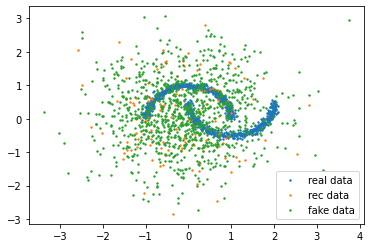

step 1000: KL: 5.273e+00, rec: -4.649e-01


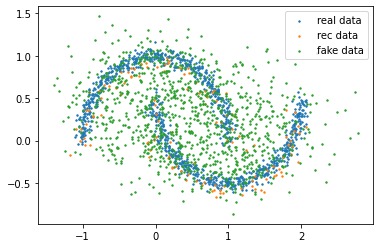

step 2000: KL: 5.726e+00, rec: -3.599e+00


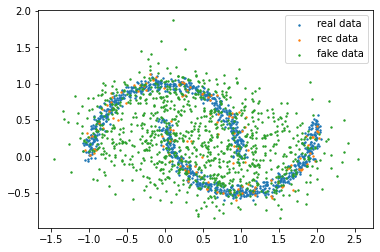

step 3000: KL: 6.069e+00, rec: -4.221e+00


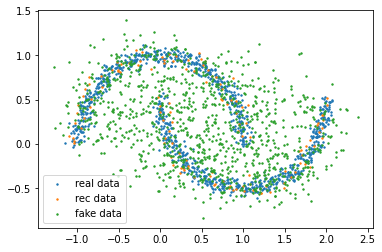

step 4000: KL: 6.342e+00, rec: -2.519e+00


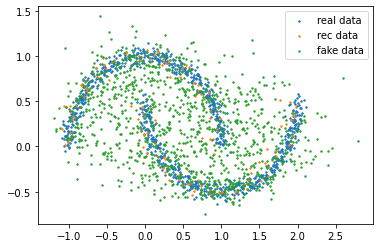

step 5000: KL: 6.454e+00, rec: -4.471e+00


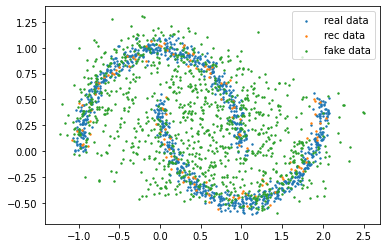

step 6000: KL: 6.506e+00, rec: -4.130e+00


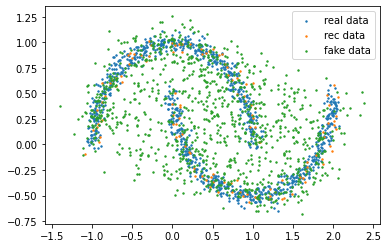

step 7000: KL: 6.573e+00, rec: -4.883e+00


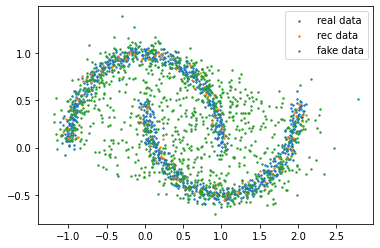

step 8000: KL: 6.737e+00, rec: -4.609e+00


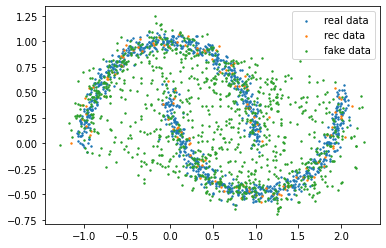

step 9000: KL: 6.617e+00, rec: -5.292e+00


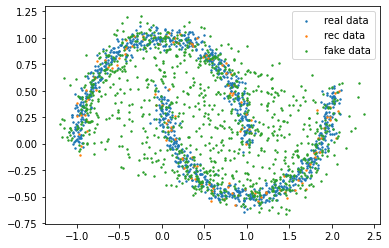

step 10000: KL: 6.710e+00, rec: -5.118e+00


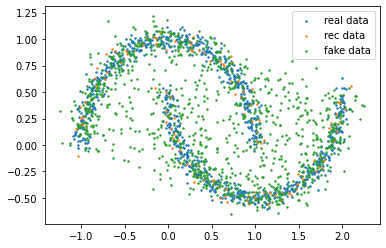

step 11000: KL: 6.753e+00, rec: -5.373e+00


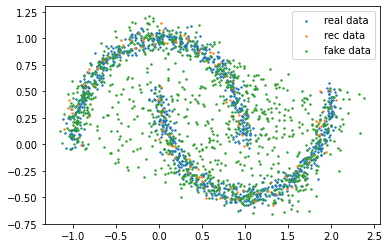

step 12000: KL: 6.721e+00, rec: -4.575e+00


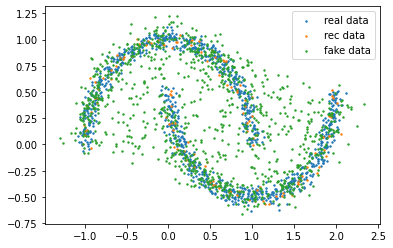

step 13000: KL: 6.824e+00, rec: -5.637e+00


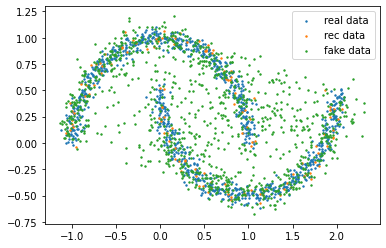

step 14000: KL: 6.817e+00, rec: -5.204e+00


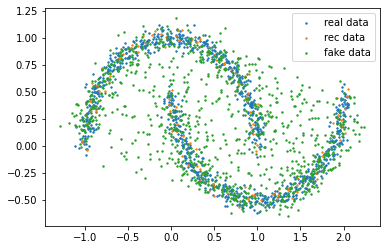

step 15000: KL: 6.772e+00, rec: -5.550e+00


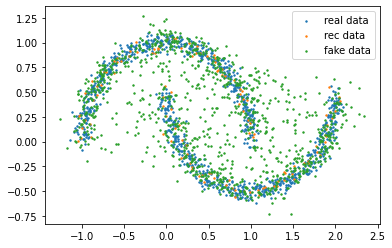

step 16000: KL: 6.884e+00, rec: -5.630e+00


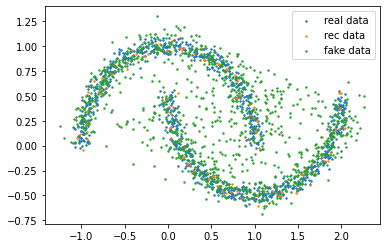

step 17000: KL: 6.955e+00, rec: -2.135e+00


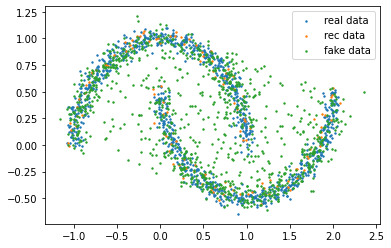

step 18000: KL: 6.865e+00, rec: -5.674e+00


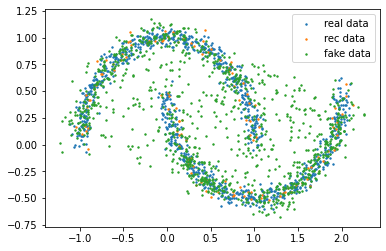

step 19000: KL: 6.817e+00, rec: -5.793e+00


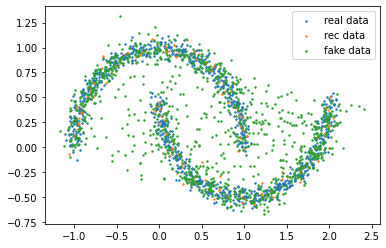

step 20000: KL: 6.966e+00, rec: -5.753e+00


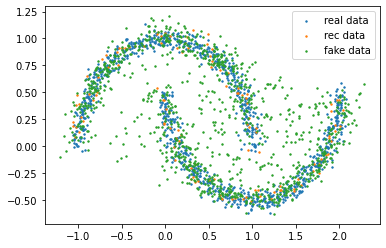

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 20001
# Batch size to use
BATCHLEN = 128
L_SAMPLE = 8

encoder = Encoder(depth=3, width=128)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder(depth=3, width=128)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
  
    # Encoder pass
    enc_mu, enc_logvar = encoder(x)
    # Compute the KL part of the loss
    loss_kl = torch.mean(0.5 * torch.sum( -enc_logvar -1 + enc_logvar.exp() + enc_mu**2, axis = 1), axis = 0)

    # Sample z from q(z|x)
    z = enc_mu[:,None,:] + (0.5*enc_logvar).exp()[:,None,:] * torch.randn((BATCHLEN,L_SAMPLE,LATENT_N)) 
    # Decoder pass
    dec_mu, dec_logvar = decoder(z)
    if HARDCODE:
        dec_logvar = dec_logvar.fill_(2*np.log(sigma_theta))
    # Compute the reconstruction part of the loss here
    loss_rec = torch.mean(0.5 * torch.sum( np.log(2*np.pi) + dec_logvar + (dec_mu-x[:,None,:])**2 / dec_logvar.exp(), axis=2), axis=(1,0))
     
    loss = 0.5*loss_kl + loss_rec
    loss.backward()
    
    optim_enc.step()
    optim_dec.step()
    
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0,0], rec_batch[:,0,1], s=2.0, label='rec data')
        # plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

> **Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10
HARDCODE = True
sigma_theta= 1e-4

# Define the generator
class Encoder(nn.Module):
    def __init__(self, depth=2, width=16):
        super().__init__()

        self.fc_0 = nn.Linear(2, width)
        self.fcs = nn.ModuleList()
        for _ in range(depth-2):
            self.fcs.append(nn.Linear(width, width))
        self.fc_last_mu = nn.Linear(width, LATENT_N)
        self.fc_last_logvar = nn.Linear(width, LATENT_N)

        self.activation = nn.ReLU()
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        h = self.activation(self.fc_0(x))
        for fc in self.fcs:
            h = self.activation(fc(h))
        mu = self.fc_last_mu(h)
        logvar = self.fc_last_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, depth=2, width=16):
        super().__init__()
        self.fc_0 = nn.Linear(LATENT_N, width)
        self.fcs = nn.ModuleList([nn.Linear(width, width) for _ in range(depth-2)])

        self.fc_last_mu = nn.Linear(width, 2)
        self.fc_last_logvar = nn.Linear(width, 2)

        self.activation = nn.ReLU()
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        h = self.activation(self.fc_0(z))
        for fc in self.fcs:
            h = self.activation(fc(h))
        mu = self.fc_last_mu(h)
        logvar = self.fc_last_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        if HARDCODE:
            logvar = logvar.fill_(2*np.log(sigma_theta))
        return torch.normal(mu, torch.exp(0.5*logvar))

# Total number of training iterations for the VAE
N_ITER = 20001
# Batch size to use
BATCHLEN = 128
L_SAMPLE = 8

encoder = Encoder(depth=4, width=64)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder(depth=4, width=64)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
  
    # Encoder pass
    enc_mu, enc_logvar = encoder(x)
    # Compute the KL part of the loss
    loss_kl = torch.mean(0.5 * torch.sum( -enc_logvar -1 + enc_logvar.exp() + enc_mu**2, axis = 1), axis = 0)

    # Sample z from q(z|x)
    z = enc_mu[:,None,:] + (0.5*enc_logvar).exp()[:,None,:] * torch.randn((BATCHLEN,L_SAMPLE,LATENT_N)) 
    # Decoder pass
    dec_mu, dec_logvar = decoder(z)
    if HARDCODE:
        dec_logvar = dec_logvar.fill_(2*np.log(sigma_theta))
    # Compute the reconstruction part of the loss here
    loss_rec = torch.mean(0.5 * torch.sum( np.log(2*np.pi) + dec_logvar + (dec_mu-x[:,None,:])**2 / dec_logvar.exp(), axis=2), axis=(1,0))
     
    loss = 0.6*loss_kl + loss_rec
    loss.backward()
    
    optim_enc.step()
    optim_dec.step()
    
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0,0], rec_batch[:,0,1], s=2.0, label='rec data')
        # plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

When hardcoding the value of $\sigma_\theta$, the VAE fails to learn how to generate distributions that are like the original one. One explaination is that during the learning, the network cannot adapt the variance of the samples generated from $q(z|x)$, therefore, to lower the loss it cannot change this parameter, meaning that only the mean can effectively lower the loss. It is easy to see that the network can be trapped in a local minimum (in the lower half moon for instance). If the network wants to find another mean that would represent the upper half moon distribution, it would have to make the mean go through a part of the space where there is no original points, and the loss would increase. Conversely, if the variance is not fixed, the upper half moon could be found and the network would be able to move the mean without having to increase the loss.

> **Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

We can make remarks similar than the one for the GAN:
  - The bigger the network, the more computationaly heavy the method becomes (longer to train) 
  - The more complex the architectures are, the more complex distributions the VAE is able to encode. For example, in the case of networks with infinite power of degrees of freedom, we can imagine that the VAE can reduce the original distribution to $1$ dimension and that the decoder would still be able to reconstruct the datapoints.
  - However, we observed that if the power is too large, the VAE fails to generate accurate distributions. This is explained by the fact that the too high power of the VAE leads to a severe overfitting implying that some points of the latent space will give meaningless content once decoded.

Therefore, the power should be high enough to encode complex distributions but low enough to avoid overfitting. We can note that the depth of the network has a higher impact than the width since it is what impact more the degrees of freedom and it is what brings non linearities.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_Z = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_X$ this obtained distribution, that is, the image of $p_Z$ through $f^{-1}$: $p_X$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_X$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_Z} g(f^{-1}(z)) dz = \int_{x\sim p_{X}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_Z(z) = \int_{x} g(x) \;dp_{X}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

> **Q14: Justify the above equality**

Using the change of variable theorem for $x=f^{-1}(z)$, we know that $ p_X(x) \left \vert \det \frac{dx}{dz} \right \vert  = p_Z(z)$ 

$$ \begin{aligned}
\log(p_X(x)) 
&= \log(p_Z(z)) - \log \left( \left \vert \det \frac{dx}{dz} \right \vert \right) \\
&= \log(p_Z(z)) - \log \left( \left \vert \det \frac{d f^{-1}(z)}{dz} \right \vert \right) \\
&= \log(p_Z(z)) - \log \left( \left \vert \det \left( \frac{d f (f^{-1}(z))}{dx} \right)^{-1} \right \vert \right) \quad \textrm{(using the inverse function theorem)}\\
&= \log(p_Z(z)) - \log \left( \left \vert \det \left( \frac{d f (x)}{dx} \right)^{-1} \right \vert \right) \\
&= \log(p_Z(z)) + \log \left( \left \vert \det J_f \right \vert \right)  \quad \text{ (using the Jacobian of an invertible function)} 
\end{aligned}$$

We denote by $p_G$ the distribution $p_X$, for $G$ meaning generated (compared to $D$ as data). 
Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

> **Q15: Express this loss as a (very simple) function of the quantity above.**

For $x= f^{-1}(z)$,
$$ \begin{aligned}
KL(p_D \Vert p_G) 
&= \sum_{x \in \mathcal X} p_D(x) \log \left( \frac{p_D(x)}{p_G(x)} \right)  \\
&= \sum_{x \in \mathcal X} p_D(x) \log (p_D(x)) - p_D(x) \log (p_G(x)) \\
&= \sum_{x \in \mathcal X} p_D(x) \left[ \log (p_D(x)) - \log (p_Z(z)) -   \log \left( \left \vert \det J_f(x) \right \vert \right) \right] \\
&= Cte - \mathbb E_{x \sim p_D} \big[ \log (p_Z(z)) + \log \left( \left \vert \det J_f(x) \right \vert \right) \big] \\
\end{aligned} $$ 


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

> **Q16: Show that the defined mapping is indeed invertible**

One has:

$$\begin{cases}
y_{1:d} &= x_{1:d} \\ 
y_{d+1:D} &= x_{d+1:D} \odot \exp({s(x_{1:d})}) + t(x_{1:d})
\end{cases}
\Leftrightarrow 
\begin{cases}
x_{1:d} &= y_{1:d} \\ 
x_{d+1:D} &= (y_{d+1:D} - t(y_{1:d})) \odot \exp(-s(y_{1:d}))
\end{cases}$$

Therefore the defined mapping is invertible.

> **Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

Denote by $J$ the Jacobian of $y$ as a function of $x$. One has:
$$
J = 
\begin{bmatrix}
  I_d & O_{d\times(D-d)} \\
  \frac{dy_{d+1:D}}{dx_{1:d}} & Diag(\exp(s(\mathbf{x}_{1:d})))
\end{bmatrix}
$$
Since the Jacobian is triangular, one has $\det (J) = \exp \left(\sum_j s(x_{1:d})_j \right)$

> **Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        self.mask = mask #we use the mask variable to make the cut in input

        self.s = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, hidden_size), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size), 
            nn.Tanh())
        self.t = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, hidden_size), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size), 
            nn.Tanh())

    def sfun(self, x_m):
        return self.s(x_m)
        
    def tfun(self, x_m):
        return self.t(x_m)
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m) # multiplicative block
        t_out = self.tfun(y_m) # additive block
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.016974
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.040341
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.049745
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.052217
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.054900
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.054519
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.056138
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055456
====> Epoch: 1 Average train loss: -0.0488


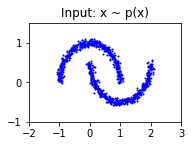

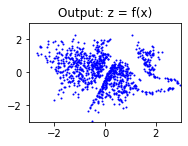

====> Test loss: -0.0578


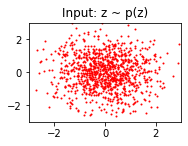

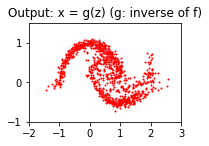

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.056842
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.057448
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.056956
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.058025
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057908
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058136
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.058103
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058255
====> Epoch: 2 Average train loss: -0.0575


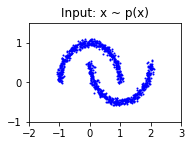

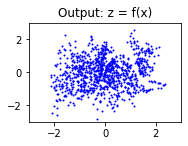

====> Test loss: -0.0597


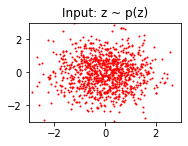

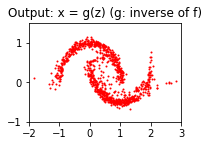

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.058509
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058713
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.057877
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058842
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058460
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.057532
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.058204
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.057906
====> Epoch: 3 Average train loss: -0.0582


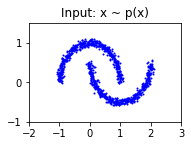

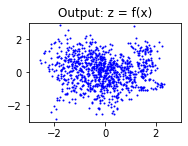

====> Test loss: -0.0600


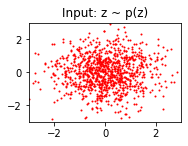

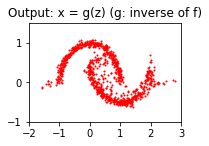

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058669
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.058374
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058434
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059147
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.058458
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058491
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.057956
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.058754
====> Epoch: 4 Average train loss: -0.0585


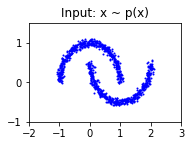

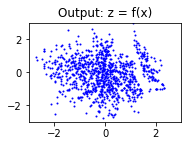

====> Test loss: -0.0599


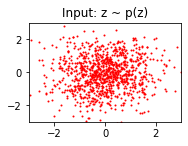

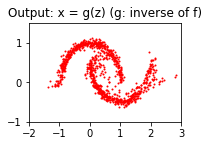

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.058601
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.058102
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.058152
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058618
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.058699
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.058190
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.058609
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.058714
====> Epoch: 5 Average train loss: -0.0585


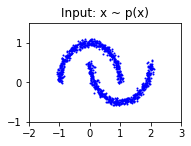

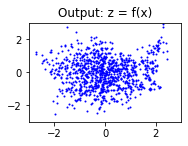

====> Test loss: -0.0602


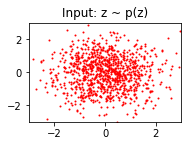

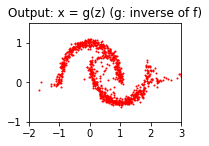

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.058275
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059305
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.058446
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.058944
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.056829
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.058509
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058781
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.057832
====> Epoch: 6 Average train loss: -0.0587


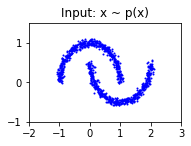

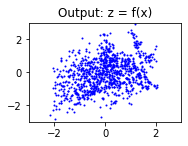

====> Test loss: -0.0596


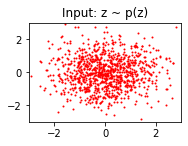

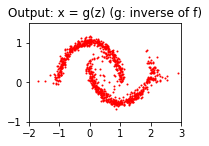

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.057816
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058731
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.058285
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.059230
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.058490
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.058994
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059402
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.058701
====> Epoch: 7 Average train loss: -0.0588


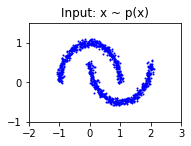

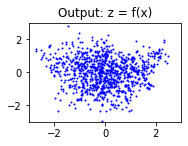

====> Test loss: -0.0604


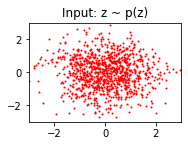

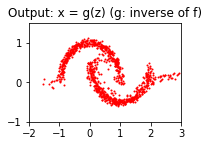

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.060069
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.058771
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059330
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.057797
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059613
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059729
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059425
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059172
====> Epoch: 8 Average train loss: -0.0588


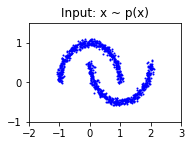

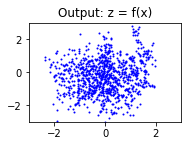

====> Test loss: -0.0600


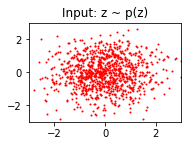

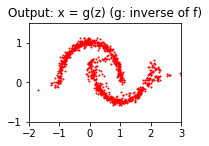

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.058548
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.058583
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.058552
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.057813
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.058317
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058824
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059275
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059101
====> Epoch: 9 Average train loss: -0.0589


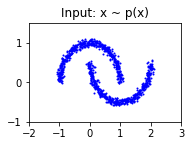

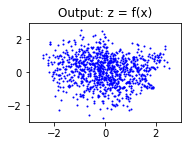

====> Test loss: -0.0605


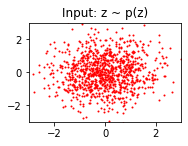

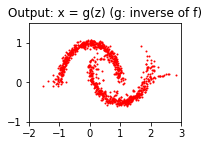

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.058802
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058195
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059204
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059289
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059335
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.058582
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.058780
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.058670
====> Epoch: 10 Average train loss: -0.0589


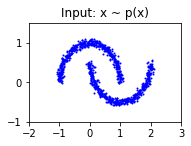

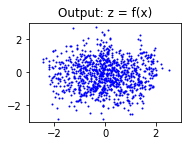

====> Test loss: -0.0606


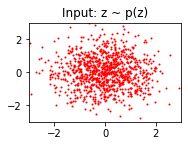

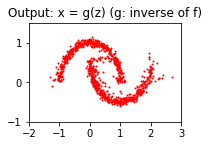

'153.22s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

> **Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

Given the parametrization of the generator $g$ as a neural network, the mapping from $z$ to $x$ is a continuous function. Therefore, in order for the network to generate different clusters from the original Gaussian input, it needs to have a Jacobian with highly varying magnitude, and possibly too big too store/ do computation with. It can lead to numerical instabilities when using the log-likelihood for instance. In addition, transforming the Gaussian noise into a high number of clusters would need the network to be very non-linear, thus to have many layers, which would imply even more computation with Jacobians.

This is what makes it hard for normalizing flows to model data where there are many clusters

> **Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

**GAN**

- (-) GANs minimize a classification loss between the input and the transformed noise distributions. Therefore, it is hard to quantitavely evaluate a GAN (and to compare 2 representations), since the discriminator loss can be very low whereas the GAN generates poor data. 
- (-) Training GANs is not easy, since it can fall into mode collapse if not careful enough. A good training is the result of a good equilibrium found between the generator and the discriminator, found in the minimax game between the 2 networks.
- (+ or -) GAN is "less subject to density", and can generate very sharp distributions (like 2D curves in the previous example), because doing so can minimize the discriminator loss.
- (+) They generalize well for different type of data like images. If well trained, they can generate extremely realistic images. 

**VAE**

- (+) VAEs optimize a lower bound on the (log) likelihood. Therefore, they present the advantage that there is a clear and recognized way to evaluate the quality of the model (its log-likelihood). Compared to GAN, VAEs know when they fail to reproduce realistic data.
- (-) VAE also revealed themselves to be hard to train. The impact of the 2 components of the loss must be studied to know how to weight them, and it can depend on the power of the encoder and decoder networks. However, the training process do not lead to mode collapse or vanishing gradients.
- (+ or -) VAE generate smooth distributions, because maximizing likelihood yields an estimated density that always bleeds probability mass away from the estimated data manifold.

**Normalizing Flow**

- (+) Normalizing Flow based models optimize an exact estimate of the likelihood of the sample, as well as in the reverse direction. As in VAE, they present the advantage to have a clear way to be evaluated and compared.
- (+) Normalizing Flow based models were easy to train in our case.
- (-) They are rather computationally expansive since they need to compute the Jacobian determinant of the transformation. In fact, there is a tradeoff between the expressivity of the model and the efficiency with which it can be computed.
- (-) They do not work well for sparse or multi-modal distributions. 